In [1]:
#Import required Libraried
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import re
import difflib
from  selenium.common import exceptions
import requests 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as ptl
from bs4 import BeautifulSoup
import nltk
import string
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import aspose.words as aw
import torch
import librosa
import numpy as np
import soundfile as sf
from scipy.io import wavfile
from IPython.display import Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from transformers import HubertForCTC, Wav2Vec2Processor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Harshit
[nltk_data]     Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Defining function to automate google search and scrape data from websites
options = Options()
options.add_argument("headless")
def googleSearch(query):

    #Assigning chrome drivers
    driver = webdriver.Chrome(options=options, executable_path='chromedriver')
    search_engine = "https://www.google.com/search?q="
    query = query.replace(" ","+")
    #getting first page of google search result of query.
    driver.get(search_engine + query + "&start=" + "0")

    df = {}
    
    #Function to clean scraped data
    stopwords=nltk.corpus.stopwords.words('english')
    def clean_text(text):
        edited_text=re.sub('\W'," ",text) #replace any sumbol with whitespace
        edited_text=re.sub("  "," ",edited_text) #replace double whitespace with single whitespace
        edited_text=edited_text.split(" ") #split the sentence into array of strings
        edited_text=" ".join([char for char in edited_text if char!= ""]) #remove any empty string from text
        edited_text=edited_text.lower() #lowercase
        edited_text=re.sub('\d+',"",edited_text) #Removing numerics
        edited_text=re.split('\W+',edited_text) #spliting based on whitespace or whitespaces
        edited_text=" ".join([word for word in edited_text if word not in stopwords]) #Snowball Stemmer
        return edited_text

    s_len = 10
    #Defining all posibel Xpaths of the search results
    for s_block in range(1 , s_len+1):
        content_block_xpath1 = f'''//*[@id="rso"]/div[{s_block}]/div/div/div[1]/div/div'''
        content_block_xpath2 = f'''//*[@id="rso"]/div[{s_block}]/div/div/div'''
        content_block_xpath3 = f'''//*[@id="rso"]/div[{s_block}]/div/div'''
        content_block_xpath4 = f'''//*[@id="rso"]/div[{s_block}]/div[2]/div'''

        # Urls through xpaths
        xpath_url1 = f"""{content_block_xpath1}/div[1]/div/a"""
        xpath_url2 = f"""{content_block_xpath2}/div[1]/div/a"""
        xpath_url3 = f"""{content_block_xpath3}/div[1]/div/a"""
        xpath_url4 = f"""{content_block_xpath4}/div[1]/div/a"""

        # Creating list of all search results website links 
        try:
            block = {}
            links = []
            try:
                url1 = driver.find_elements('xpath', xpath_url1)
                for url in url1:
                    links.append(url.get_attribute("href"))
            except:
                pass
            try:
                url2 = driver.find_elements('xpath', xpath_url2)
                for url in url2:
                    links.append(url.get_attribute("href"))
            except:
                pass
            try:
                url3 = driver.find_elements('xpath', xpath_url3)
                for url in url3:
                    links.append(url.get_attribute("href"))
            except:
                pass
            try:
                url4 = driver.find_elements('xpath', xpath_url4)
                for url in url4:
                    links.append(url.get_attribute("href"))
            except:
                pass
            #Finding domain by regular expression
            pattern =  r"""(https?:\/\/)?(([a-z0-9-_]+\.)?([a-z0-9-_]+\.[a-z0-9-_]+))"""
            if len(links) == 0:
                domain = re.search(pattern,'')
            else: 
                domain = re.search(pattern, links[0])
            if len(links)==0:
                final_text = ''
            else:
                def getdata(url): 
                    try:
                        r = requests.get(url)
                        return r.text
                    except:
                        r = ''
                        return r 
                # Scrapping paragraphs of websites and storing in a dictionary after cleaning
                htmldata = getdata(links[0]) 
                soup = BeautifulSoup(htmldata, 'html.parser') 
                data = '' 
                content = []
                for data in soup.find_all("p"): 
                    content.append(data.get_text())
                text_content = ' '.join(content)
                final_text = clean_text(text_content)
            block["domain"] = domain
            if len(links)==0:
                block["url"] = ''
            else:
                block["url"] = links[0]
            block["description"] = final_text

            df[f'{s_block}'] = block

        except exceptions.NoSuchElementException:
            continue
#using Try and Except on different stages to mange any error
        if len(df) == 0:
            raise Exception("No data found")

    driver.close()
    return df

In [3]:
#Pretrained models to convert Audion Wav file to Text
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
text = 'Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.'

In [5]:
#Converting all types of files (Audio, Doc., Txt.) in to simple text file.
File = 'example.txt'
if text is not None:
    file = open('Output.txt', 'w')
    file.write(text)
    file.close()
else:
    if File.endswith('.docx'):
        doc = aw.Document(File)
        doc.save("Output.txt")
    elif File.endswith('.txt'):
        file = open(File, 'r')
        a = file.read()
        file = open('Output.txt', 'w')
        file.write(a)
        file.close()
    elif File.endswith('.wav'):
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")
        speech, rate = librosa.load(File, sr=16000)
        input_values = processor(speech, return_tensors="pt", sampling_rate=rate).input_values
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)
        audio_text = ' '.join(transcription)
        file = open('Output.txt', 'w')
        file.write(str(audio_text))
        file.close()

In [6]:
#Read Output.txt
file = open('Output.txt', 'r')
a = file.read()
print(a)

Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.


In [7]:
#Split the text file by new line to create pandas dataframe
files = ['Output.txt']
da = {}
for f in files:
    with open (f, "r",encoding="utf8") as myfile:
        all_lines = myfile.read().splitlines() #Spliting 
        da['Text'] = all_lines
df = pd.DataFrame(da)
df

,Text
0,Python is dynamically-typed and garbage-collec...


In [8]:
#Removing small sentences, headings, titles row from dataframe
for i in range(len(df['Text'])):
    if len(df['Text'][i]) < 100:
        df = df.drop(i)

In [9]:
#Cleaning text and storing in new column
stopwords=nltk.corpus.stopwords.words('english')
def clean_text(text):
    edited_text=re.sub('\W'," ",text) #replace any sumbol with whitespace
    edited_text=re.sub("  "," ",edited_text) #replace double whitespace with single whitespace
    edited_text=edited_text.split(" ") #split the sentence into array of strings
    edited_text=" ".join([char for char in edited_text if char!= ""]) #remove any empty string from text
    edited_text=edited_text.lower() #lowercase
    edited_text=re.sub('\d+',"",edited_text) #Removing numerics
    edited_text=re.split('\W+',edited_text) #spliting based on whitespace or whitespaces
    edited_text=" ".join([word for word in edited_text if word not in stopwords])
    return edited_text
df['Treated_Text']=df.Text.apply(lambda x: clean_text(x))
df

,Text,Treated_Text
0,Python is dynamically-typed and garbage-collec...,python dynamically typed garbage collected sup...


In [10]:
#Applying google search function on each row and store in dictionary
final = {}
for i in range(len(df['Treated_Text'])):
    final[f'{i}'] = googleSearch(f'{df.Treated_Text[i]}')

In [11]:
#final scraped data
final

{'0': {'1': {'domain': <re.Match object; span=(0, 24), match='https://www.linkedin.com'>,
   'url': 'https://www.linkedin.com/pulse/python-programming-language-vanshika-munshi',
   'description': 'python high level general purpose programming language design philosophy emphasizes code readability use significant indentation python dynamically typed garbage collected supports multiple programming paradigms including structured particularly procedural object oriented functional programming often described batteries included language due comprehensive standard library guido van rossum began working python late successor abc programming language first released python python released introduced new features list comprehensions cycle detecting garbage collection reference counting unicode support python released major revision completely backward compatible earlier versions python discontinued version python consistently ranks one popular programming languages view add comment sign view add 

Could be copied form: - <re.Match object; span=(0, 24), match='https://www.linkedin.com'>
Could be copied form: - <re.Match object; span=(0, 24), match='https://en.wikipedia.org'>
Could be copied form: - <re.Match object; span=(0, 28), match='https://embeddedartistry.com'>
Could be copied form: - <re.Match object; span=(0, 18), match='https://golden.com'>
Could be copied form: - <re.Match object; span=(0, 35), match='https://www.whitebandassociates.com'>


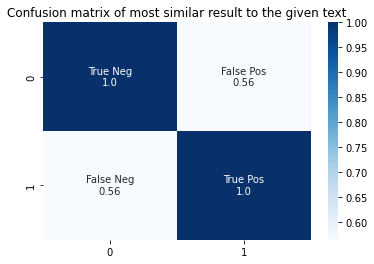

In [12]:
#Applying cosine similarity by vectorizing user text and scraped text
web=[]
plt=[]
position = []
for i in final:
    for j in final[i]:
        arr = [df.Treated_Text[int(i)],final[i][j]["description"]]
        #TFIDF Vectorization
        vectorizer = TfidfVectorizer()
        obj = vectorizer.fit_transform(arr)
        vectors = obj.toarray() 
        sim = round(cosine_similarity(vectors)[0][1],2)
        if sim>0.30:
            # Creating list of matched websites indexs of final dictionary
            position.append(j)
            #List of matched sites score and weblink
            plt.append(sim)
            link = str(final[i][j]["domain"])
            link_list = link.split(',')
            web.append(link_list[2])
            print(f'Could be copied form: - {final[i][j]["domain"]}')
    #displaying Most similar website similarity score confusion matrix       
    for k in range(len(plt)):
        if plt[k] == max(plt):
            l = [df.Treated_Text[int(i)],final[i][str(position[k])]["description"]]
            vectorizer = TfidfVectorizer()
            m = vectorizer.fit_transform(l)
            vec = m.toarray()
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            group_counts = ["{0:.2}".format(value) for value in cosine_similarity(vec).flatten()]
            labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)
            ptl.title("Confusion matrix of most similar result to the given text")
            sns.heatmap(cosine_similarity(vec), annot=labels, fmt='', cmap='Blues')

In [13]:
#Dataframe of weblinks and their similarity score
list_of_tuples = list(zip(web, plt))
data = pd.DataFrame(list_of_tuples,columns=['Source URL', 'Similarity score'])

In [14]:
data

,Source URL,Similarity score
0,match='https://www.linkedin.com'>,0.51
1,match='https://en.wikipedia.org'>,0.31
2,match='https://embeddedartistry.com'>,0.43
3,match='https://golden.com'>,0.56
4,match='https://www.whitebandassociates.com'>,0.39


### Part-2 Paraphrasing

In [15]:
#Importing libraries for Paraphrasing
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import warnings
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\Harshit
[nltk_data]     Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
text = 'Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.'

In [17]:
#T5 pretrained model for paraphrasing
tokenizer = AutoTokenizer.from_pretrained("prithivida/parrot_paraphraser_on_T5")
model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/parrot_paraphraser_on_T5")

In [18]:
# Parameters Tuning of model.
#Tockening and applying model on text
def paraphraser(para):
    sentence = "paraphrase: " + para + " </s>"
    encoding = tokenizer.encode_plus(sentence,padding=True, return_tensors="pt")
    #Encoding tokens and masks
    input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]
    outputs = model.generate(input_ids=input_ids, attention_mask=attention_masks,
                             max_length=256,
                             do_sample=True,
                             top_k=120,
                             top_p=0.95,
                             early_stopping=True,
                             num_return_sequences=1)
    #Decoding generated output 
    output = tokenizer.decode(outputs[0], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    return(output)
 
output = " ".join([paraphraser(sent) for sent in sent_tokenize(text)])
#Final Paraphrased sentence
print(output)

Python is dynamically typed and garbage collected. '' It supports multiple programming paradigms including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its vast standard library.
